In [2]:
from obspy.clients.seedlink.easyseedlink import create_client
from obspy import Trace, UTCDateTime, Stream
from obspy.clients.fdsn import Client as FDSNclient
from obspy.core.inventory import Inventory
import matplotlib.pyplot as plt
import time
from obspy import UTCDateTime
from bs4 import BeautifulSoup
import requests
import logging.handlers
import numpy as np
import logging
from multiprocessing import Queue
import pandas as pd
from filtering import filtering_data
from fourier import fourier_transform
from core import main_processing


In [3]:
datasource = pd.read_csv("processed_ds2_partial.csv")

In [4]:
datasource.columns

Index(['index', 'datetime', 'lat', 'lon', 'depth', 'mag', 'Rms', 'Int',
       'sensed', 'lat_decimal', 'lon_decimal', 'dist_MORF', 'Domin_freq_z',
       'Domin_freq_n', 'Domin_freq_e', 'P-peak2peak', 'P-Vel amp (m/s)',
       'P-Disp amp (m)', 'P-r', 'P-moment_history', 'P-tau_c', 'S-peak2peak',
       'S-Vel amp (m/s)', 'RMS', 'S-Disp amp (m)', 'S-r', 'Energy',
       'S-moment_history', 'peak_freq', 'S-tau_c', 'wavelength', 'other infos',
       'peak_disp', 'M0'],
      dtype='object')

In [5]:
columns_datasource = ['index', 'datetime', 'lat', 'lon', 'depth', 'mag', 'Rms', 'Int',
       'sensed', 'lat_decimal', 'lon_decimal', 'dist_MORF', 'Domin_freq_z',
       'Domin_freq_n', 'Domin_freq_e', 'P-peak2peak', 'P-Vel amp (m/s)',
       'P-Disp amp (m)', 'P-r', 'P-moment_history', 'P-tau_c', 'S-peak2peak',
       'S-Vel amp (m/s)', 'RMS', 'S-Disp amp (m)', 'S-r', 'Energy',
       'S-moment_history', 'peak_freq', 'S-tau_c', 'wavelength', 'other infos',
       'peak_disp', 'M0']

In [6]:
def classify(row):
    if row == "V/VI":
        return 6
    elif row == "V":
        return 5
    elif row == "IV/V":
        return 4.5
    elif row == "IV":
        return 4
    elif row =="III/IV":
        return 3.5
    elif row == "III":
        return 3
    elif row =="II/III":
        return 2.5
    elif row =="II":
        return 2
    elif row == "I/II":
        return 1.5
    elif row == "I":
        return 1
    else:
        return 0

datasource["num_int"] = datasource["Int"].apply(lambda x :classify(x))

In [7]:
datasource2= datasource.__deepcopy__()

datasource2 = datasource2.drop(["Int", "lat", "lon", "Rms", "mag"], axis=1)
datasource2.isna().sum()
datasource2 = datasource2.dropna(axis=0)

datasource2["Domin_freq_n"] = abs(datasource2["Domin_freq_n"])
datasource2["Domin_freq_e"] = abs(datasource2["Domin_freq_e"])
datasource2["Domin_freq_z"] = abs(datasource2["Domin_freq_z"])
datasource2["P-Vel amp (m/s)"] = abs(datasource2["P-Vel amp (m/s)"])
datasource2["S-Vel amp (m/s)"] = abs(datasource2["S-Vel amp (m/s)"])
datasource2["P-Disp amp (m)"] = abs(datasource2["P-Disp amp (m)"])
datasource2["S-Disp amp (m)"] = abs(datasource2["S-Disp amp (m)"])

datasource2["Mw"] = 4.525*np.log10(datasource2["P-tau_c"]) +5.036


true_features = datasource2[['Domin_freq_z','Domin_freq_n', 'Domin_freq_e', 'P-peak2peak', 'P-Vel amp (m/s)',
       'P-Disp amp (m)', 'P-r', 'P-moment_history', 'P-tau_c'
       #,'S-peak2peak','S-Vel amp (m/s)','S-Disp amp (m)', 'S-r','S-moment_history', 'S-tau_c'
       ,'RMS',  'Energy','peak_freq', 'wavelength', 'other infos', 'peak_disp', 'M0', "Mw"]]

target = datasource2[["sensed"]]

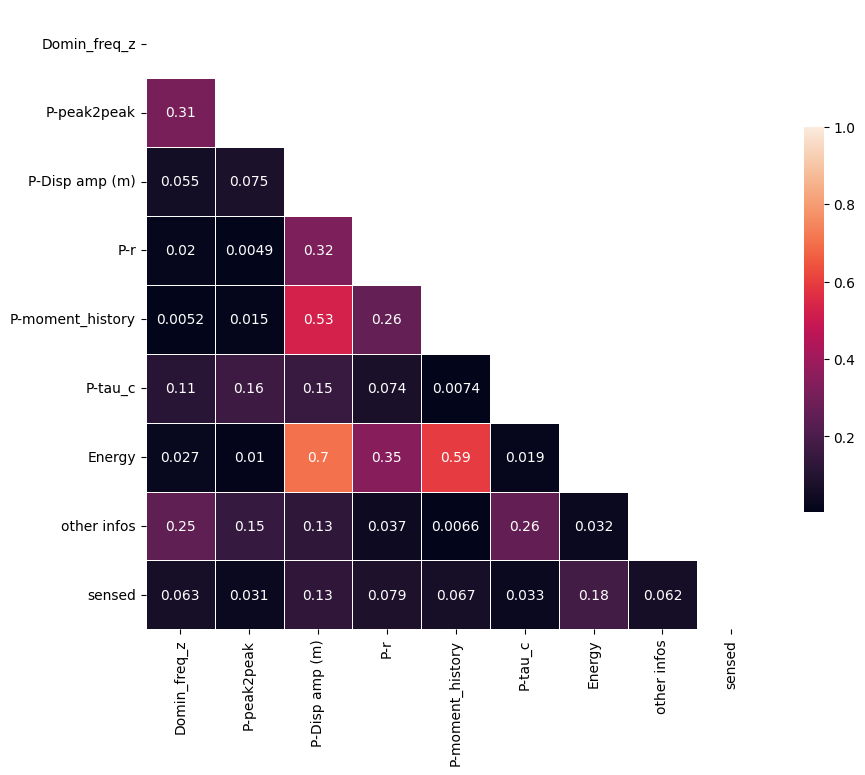

In [9]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

features = datasource2[['Domin_freq_z','P-peak2peak', #'P-Vel amp (m/s)',
       'P-Disp amp (m)', 'P-r', 'P-moment_history', 'P-tau_c'
       #,'S-peak2peak','S-Vel amp (m/s)','S-Disp amp (m)', 'S-r','S-moment_history', 'S-tau_c'
       #,'RMS'
       ,  'Energy', 'other infos', "sensed"]]

corr=np.abs(features.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()



In [79]:
## starting ML
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, precision_score, accuracy_score, recall_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [11]:
features = features.drop("sensed", axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)
y_test = np.array(y_test).ravel()

In [12]:
# Normalize only the numerical features
normalizer = MinMaxScaler()
normalizer.fit(X_train)

# Transform the numerical features
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Convert to DataFrame, keeping the original indices
X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index)
X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index)

In [114]:
features2 = datasource2[['Domin_freq_z',#'P-peak2peak', 'P-Vel amp (m/s)',
       #'P-Disp amp (m)',
       'P-r', 
       'P-moment_history', 'P-tau_c'
       #,'S-peak2peak','S-Vel amp (m/s)','S-Disp amp (m)', 'S-r','S-moment_history', 'S-tau_c'
       #,'RMS'
       #,  'Energy', 'other infos', "sensed"
       ]]
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(features2, target, test_size=0.20)
y_train_a = np.array(y_train_a).ravel()
logreg = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'lbfgs']  # Solvers for logistic regression
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='recall')

grid_search.fit(X_train_a, y_train_a)
best_logreg = grid_search.best_estimator_
logreg_pred_a = best_logreg.predict(X_test_a)

y_test_a = np.array(y_test_a).ravel()

precision = precision_score(y_test_a, logreg_pred_a)
accuracy = accuracy_score(y_test_a, logreg_pred_a)
recall = recall_score(y_test_a, logreg_pred_a)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9951573849878934
Precision: 0.0
Recall: 0.0


c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_norm, y_train)
lin_pred = linear_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(lin_pred, y_test))
print("RMSE", root_mean_squared_error(lin_pred, y_test))
print("R2 score", linear_reg.score(X_test_norm, y_test))

MAE 0.012750397381464525
RMSE 0.0736054695195964
R2 score 0.03560702175386288


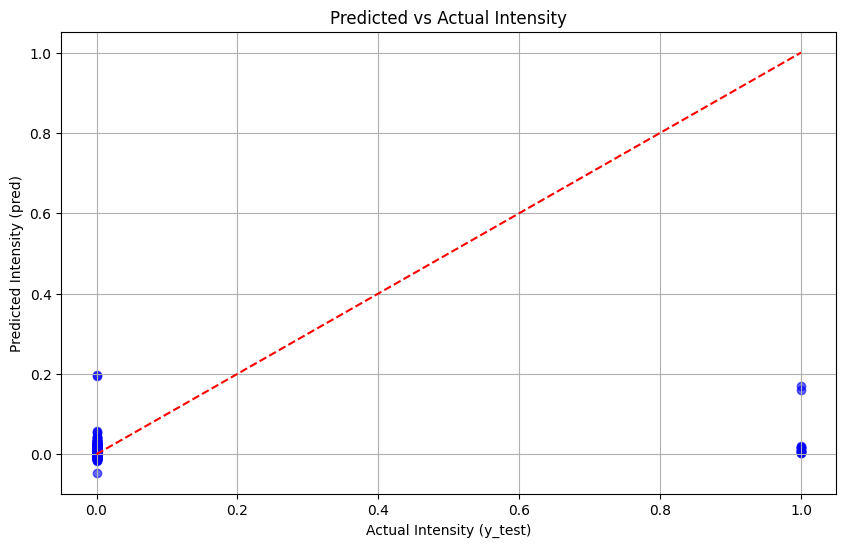

In [14]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lin_pred, color='b', alpha=0.6)

# Adding a diagonal line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')

# Adding labels and title
plt.xlabel('Actual Intensity (y_test)')
plt.ylabel('Predicted Intensity (pred)')
plt.title('Predicted vs Actual Intensity')

# Show grid
plt.grid()

# Show the plot
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(true_features, target, test_size=0.20)

y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalize only the numerical features
normalizer = MinMaxScaler()
normalizer.fit(X_train)

# Transform the numerical features
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Convert to DataFrame, keeping the original indices
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

In [17]:
## resampling
train = pd.DataFrame(X_train_norm, columns = X_train.columns)
train["sensed"] = y_train

sensed_df = train[train["sensed"]==1]
not_sensed_df = train[train["sensed"]==0]

In [18]:
from sklearn.utils import resample

fraud_df_oversampled = resample(sensed_df, n_samples=len(not_sensed_df), replace=True)
train_oversampled = pd.concat([fraud_df_oversampled, not_sensed_df])

In [19]:
y_train_over = train_oversampled["sensed"]
X_train_over = train_oversampled.drop(columns="sensed")

y_train_over = np.array(y_train_over).ravel() 

In [20]:
gb_reg = GradientBoostingClassifier(max_depth=20,
                                   n_estimators=200)
gb_reg.fit(X_train_over, y_train_over)
gb_pred = gb_reg.predict(X_test_norm)

precision = precision_score(y_test, gb_pred)
accuracy = accuracy_score(y_test, gb_pred)
recall = recall_score(y_test, gb_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9854721549636803
Precision: 0.047619047619047616
Recall: 0.058823529411764705


In [21]:
ada_reg = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                            n_estimators=200)

ada_reg.fit(X_train_over, y_train_over)
ada_pred = ada_reg.predict(X_test_norm)

precision = precision_score(y_test, ada_pred)
accuracy = accuracy_score(y_test, ada_pred)
recall = recall_score(y_test, ada_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9927360774818402
Precision: 0.0
Recall: 0.0


In [22]:
forest = RandomForestClassifier(n_estimators=200, max_depth=20)
forest.fit(X_train_over, y_train_over)
forest_pred = forest.predict(X_test_norm)

precision = precision_score(y_test, forest_pred)
accuracy = accuracy_score(y_test, forest_pred)
recall = recall_score(y_test, forest_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9927360774818402
Precision: 0.3333333333333333
Recall: 0.058823529411764705


In [26]:
bagging_reg = BaggingClassifier(DecisionTreeClassifier(max_depth=20),                               
                               n_estimators=200,
                               max_samples = 1000,
                               #bootstrap = False,
                               n_jobs=-1
                               )

bagging_reg.fit(X_train_over, y_train_over)
bag_pred = bagging_reg.predict(X_test_norm)

precision = precision_score(y_test, bag_pred)
accuracy = accuracy_score(y_test, bag_pred)
recall = recall_score(y_test, bag_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9681194511702986
Precision: 0.05714285714285714
Recall: 0.23529411764705882


In [27]:
grid = {"n_estimators": [250, 500, 750],
        "estimator__max_leaf_nodes": [150, 180, 250],
        "estimator__max_depth":[5,10]}

bagging_reg = BaggingClassifier(DecisionTreeClassifier())

model = GridSearchCV(estimator = bagging_reg, param_grid = grid, cv=5, n_jobs=-1)
model.fit(X_train_over, y_train_over)
model.best_params_

{'estimator__max_depth': 10,
 'estimator__max_leaf_nodes': 250,
 'n_estimators': 250}

In [28]:
best_model = model.best_estimator_

In [29]:
model_pred = best_model.predict(X_test_norm)

precision = precision_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9592413236481033
Precision: 0.03333333333333333
Recall: 0.17647058823529413


In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_norm, y_train)

y_train_sm = y_train_sm.ravel()

In [31]:
grid = {"n_estimators": [100, 250, 500],
        "estimator__max_leaf_nodes": [150, 250, 500],
        "estimator__max_depth":[10,20,30]}

bagging_reg = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'))

model = GridSearchCV(estimator = bagging_reg, param_grid = grid, cv=5, n_jobs=-1)
model.fit(X_train_sm, y_train_sm)
model.best_params_

{'estimator__max_depth': 30,
 'estimator__max_leaf_nodes': 500,
 'n_estimators': 500}

In [32]:
best_model = model.best_estimator_
model_pred = best_model.predict(X_test_norm)

precision = precision_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9761904761904762
Precision: 0.043478260869565216
Recall: 0.11764705882352941


In [33]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, f1_score
print(classification_report(y_true=y_test, y_pred = model_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2461
           1       0.04      0.12      0.06        17

    accuracy                           0.98      2478
   macro avg       0.52      0.55      0.53      2478
weighted avg       0.99      0.98      0.98      2478



In [34]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities with the best model
y_prob = model.best_estimator_.predict_proba(X_test_norm)[:, 1]  # Probabilities for the positive class

# Set a custom threshold
custom_threshold = 0.05  # For example, set to 0.3 to increase recall

# Make predictions based on the custom threshold
y_pred_custom_threshold = (y_prob >= custom_threshold).astype(int)


precision = precision_score(y_test, y_pred_custom_threshold)
accuracy = accuracy_score(y_test, y_pred_custom_threshold)
recall = recall_score(y_test, y_pred_custom_threshold)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7978208232445521
Precision: 0.017928286852589643
Recall: 0.5294117647058824


In [35]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities with the best model
y_prob = model.best_estimator_.predict_proba(X_test_norm)[:, 1]  # Probabilities for the positive class

# Set a custom threshold
custom_threshold = 0.05  # For example, set to 0.3 to increase recall

# Make predictions based on the custom threshold
y_pred_custom_threshold = (y_prob >= custom_threshold).astype(int)


precision = precision_score(y_test, y_pred_custom_threshold)
accuracy = accuracy_score(y_test, y_pred_custom_threshold)
recall = recall_score(y_test, y_pred_custom_threshold)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7978208232445521
Precision: 0.017928286852589643
Recall: 0.5294117647058824


Accuracy: 0.7978208232445521
Precision: 0.011928429423459244
Recall: 0.6

In [36]:
import joblib

# Assuming `model` is your trained model
##joblib.dump(model, 'model_60.pkl')
##joblib.dump(model.best_estimator_, 'best_model_high_recall.pkl')

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier

# Define grid for BalancedBaggingClassifier
param_grid = {
    'n_estimators': [100, 250, 500, 1000],
    'max_samples': [0.5, 0.75, 0.8],
    'max_features': [0.3, 0.5, 0.75],
    'estimator__max_depth': [10, 20, 30 , 50]  # Depth of the Decision Tree estimator
}

# Initialize the classifier
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'))

# Run grid search
grid_search = GridSearchCV(bagging, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_sm, y_train_sm)

# Retrieve best parameters and use them in the stacking model
best_params = grid_search.best_params_
print("Best parameters for BalancedBaggingClassifier:", best_params)

# Define base models
base_models = [
    ('bagging', BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight='balanced'),
        n_estimators=best_params['n_estimators'],
        max_samples=best_params['max_samples'],
        max_features=best_params['max_features']
    )),
    ('random_forest', RandomForestClassifier(class_weight='balanced', n_estimators=best_params['n_estimators'])),
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=best_params['n_estimators']))
]

# Define the stacking model with a meta-classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)

# Train the stacking model on the oversampled data
stacking_model.fit(X_train_sm, y_train_sm)

# Predict with the custom threshold on the stacking model
y_prob_stack = stacking_model.predict_proba(X_test_norm)[:, 1]  # Positive class probabilities
custom_threshold = 0.05  # Example threshold
y_pred_stack_custom_threshold = (y_prob_stack >= custom_threshold).astype(int)

precision = precision_score(y_test, y_pred_stack_custom_threshold ,zero_division=1)
accuracy = accuracy_score(y_test, y_pred_stack_custom_threshold)
recall = recall_score(y_test, y_pred_stack_custom_threshold)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for BalancedBaggingClassifier: {'estimator__max_depth': 30, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 250}
Accuracy: 0.9709443099273608
Precision: 0.04918032786885246
Recall: 0.17647058823529413


In [38]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define base models
base_models = [
    ('brf', BalancedRandomForestClassifier(n_estimators=150, max_depth=30, class_weight='balanced_subsample')),
    ('xgb', xgb.XGBClassifier(scale_pos_weight=15, max_depth=7, min_child_weight=2, use_label_encoder=False, eval_metric='logloss')),
    ('lgb', lgb.LGBMClassifier(class_weight={0: 1, 1: 15}, n_estimators=150, num_leaves=50))
]

## Define the stacking model with a logistic regression meta-classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5)
)

# Train the stacking model on the oversampled data
stacking_model.fit(X_train_sm, y_train_sm)

# Predict probabilities with the stacking model
y_prob_stacking = stacking_model.predict_proba(X_test_norm)[:, 1]  # Probability for the positive class

# Apply the custom threshold
custom_threshold = 0.01
y_pred_stack_custom_threshold = (y_prob_stacking >= custom_threshold).astype(int)

# Convert y_test to 1D NumPy array
y_test = np.array(y_test).ravel()  # or simply use y_test.values.ravel()

# Evaluate the stacking model
precision = precision_score(y_test, y_pred_stack_custom_threshold)
accuracy = accuracy_score(y_test, y_pred_stack_custom_threshold)
recall = recall_score(y_test, y_pred_stack_custom_threshold)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9847, number of negative: 9847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 19694, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.937500 -> initscore=2.708050
[LightGBM] [Info] Start training from score 2.708050


c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7878, number of negative: 7877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 15755, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.937507 -> initscore=2.708177
[LightGBM] [Info] Start training from score 2.708177
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7878, number of negative: 7877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 15755, number of used featu

In [39]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grids for hyperparameter tuning
param_grid_brf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 10],
    'scale_pos_weight': [5, 10, 15]
}

param_grid_lgb = {
    'n_estimators': [50, 100, 150],
    'num_leaves': [31, 50, 100],
    'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}, {0: 1, 1: 30}]
}

# Initialize base models
brf = BalancedRandomForestClassifier()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier()

# Perform RandomizedSearchCV on each model
random_search_brf = GridSearchCV(brf, param_grid_brf, cv=5, scoring='recall', n_jobs=-1)
random_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='recall', n_jobs=-1)
random_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=5, scoring='recall', n_jobs=-1)

# Fit each search to find the best model
random_search_brf.fit(X_train_sm, y_train_sm)
random_search_xgb.fit(X_train_sm, y_train_sm)
random_search_lgb.fit(X_train_sm, y_train_sm)

# Retrieve best estimators
best_brf = random_search_brf.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_lgb = random_search_lgb.best_estimator_

# Display best parameters
print("Best parameters for BalancedRandomForestClassifier:", random_search_brf.best_params_)
print("Best parameters for XGBClassifier:", random_search_xgb.best_params_)
print("Best parameters for LGBMClassifier:", random_search_lgb.best_params_)

# Define base models with best parameters
base_models = [
    ('brf', best_brf),
    ('xgb', best_xgb),
    ('lgb', best_lgb)
]

# Define the stacking model with a GradientBoostingClassifier as the meta-classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5)
)

# Train the stacking model on the oversampled data
stacking_model.fit(X_train_sm, y_train_sm)

# Predict probabilities with the stacking model
y_prob_stacking = stacking_model.predict_proba(X_test_norm)[:, 1]  # Probability for the positive class

# Apply the custom threshold
custom_threshold = 0.01
y_pred_stack_custom_threshold = (y_prob_stacking >= custom_threshold).astype(int)

# Evaluate the stacking model
precision = precision_score(y_test, y_pred_stack_custom_threshold)
accuracy = accuracy_score(y_test, y_pred_stack_custom_threshold)
recall = recall_score(y_test, y_pred_stack_custom_threshold)

print("\nStacking Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9847, number of negative: 9847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 19694, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.952381 -> initscore=2.995732
[LightGBM] [Info] Start training from score 2.995732
Best parameters for BalancedRandomForestClassifier: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 150}
Best parameters for XGBClassifier: {'max_depth': 10, 'n_estimators': 50, 'scale_pos_weight': 15}
Best parameters for LGBMClassifier: {'class_weight': {0: 1, 1: 20}, 'n_estimators': 50, 'num_leaves': 50}


c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9847, number of negative: 9847
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 19694, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.952381 -> initscore=2.995732
[LightGBM] [Info] Start training from score 2.995732


c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7878, number of negative: 7877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 15755, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.952387 -> initscore=2.995859
[LightGBM] [Info] Start training from score 2.995859
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7878, number of negative: 7877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 15755, number of used featu